# Deep Learning: Transfer Learning y Fine Tuning
#### Itzanami Berlanga Contreras | 07 de mayo del 2024

En esta práctica vamos a estudiar uno de los conceptos vistos en clase sobre el transfer learning y fine tuning, estrategias que tiene como propósito como su nombre así lo indica, de tomar el aprendizaje de un modelo, y usarlo en otro, esto tiene como propósito ayudar a mejorar el desempeño de un modelo en un problema del que se cuentan con pocos o malos datos, entrenando de forma previa al modelo con algún conjunto de naturaleza similar del que se tengan más o mejores datos, ya sea para entonces solo entrenar la capa de salida en el caso del transfer learning  o de tomarlo como referencia en el entrenamiento, partiendo de ahí aunque llevando a cabo su propio entrenamiento completo de la red, como lo es el caso del fine tuning.

## Paso 1: Generación del conjunto a trabajar

In [120]:
import keras
import numpy as np
from keras.models import Sequential
from keras.models import clone_model
from tabulate import tabulate
from keras.layers import Dense
from keras.layers import Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

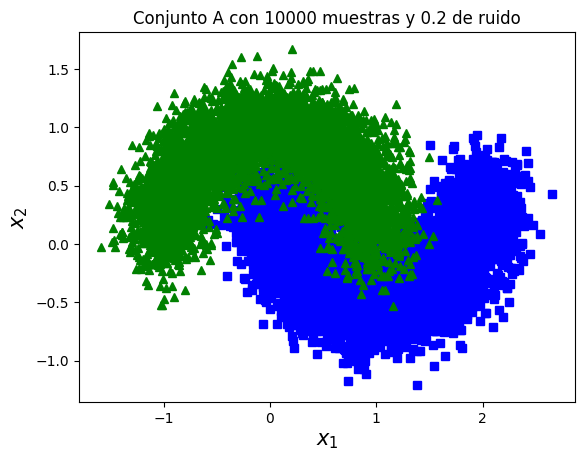

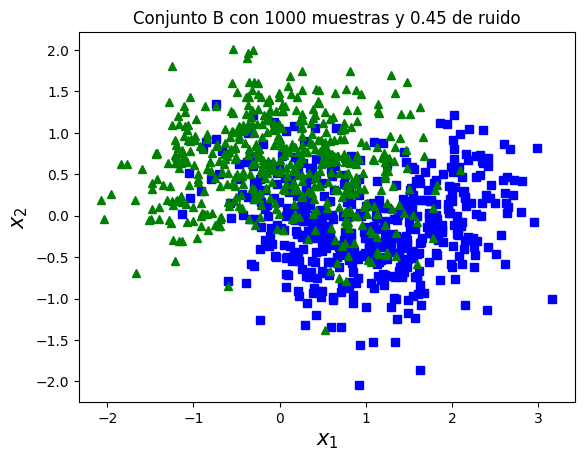

In [88]:
# Funcion para generar los conjuntos indicada
def make_moons2(ruido, muestras):
    return make_moons(n_samples=muestras, noise=ruido, random_state=17)

X_sinRuido, y_sinRuido = make_moons2(.2, 10000)
X_ruido, y_ruido = make_moons2(.45, 1000)

plt.plot(X_sinRuido[:, 0][y_sinRuido==1], X_sinRuido[:, 1][y_sinRuido==1], "bs")
plt.plot(X_sinRuido[:, 0][y_sinRuido==0], X_sinRuido[:, 1][y_sinRuido==0], "g^")

# X contains two features, x1 and x2
plt.xlabel(r"$x_1$", fontsize=15)
plt.ylabel(r"$x_2$", fontsize=15)
plt.title("Conjunto A con 10000 muestras y 0.2 de ruido")

# Displaying the plot.
plt.show()

plt.plot(X_ruido[:, 0][y_ruido==1], X_ruido[:, 1][y_ruido==1], "bs")
plt.plot(X_ruido[:, 0][y_ruido==0], X_ruido[:, 1][y_ruido==0], "g^")

# X contains two features, x1 and x2
plt.xlabel(r"$x_1$", fontsize=15)
plt.ylabel(r"$x_2$", fontsize=15)
plt.title("Conjunto B con 1000 muestras y 0.45 de ruido")
# Displaying the plot.
plt.show()

### Preparar los datos

In [89]:
esc = MinMaxScaler()
esc.fit(X_sinRuido)
esc.transform(X_sinRuido)

esc2 = MinMaxScaler()
esc2.fit(X_ruido)
esc2.transform(X_ruido)

X_SR_tr, X_SR_ts, y_SR_tr, y_SR_ts = train_test_split(X_sinRuido, y_sinRuido, test_size=0.2, stratify=y_sinRuido)

X_CR_tr, X_CR_ts, y_CR_tr, y_CR_ts = train_test_split(X_ruido, y_ruido, test_size=0.2, stratify=y_ruido)

In [90]:
def OHE(Y):
    etiq = np.unique(Y)
    oneHotEncoder = np.zeros((len(Y), len(etiq)))
    for i in range(len(Y)):
        oneHotEncoder[i] = np.zeros(len(etiq))
        for j in range(len(etiq)):
            if Y[i] == etiq[j]:
                oneHotEncoder[i][j] = 1
    return oneHotEncoder

def antiOHE(Y):
    antiEncoder = np.zeros(len(Y))
    for i in range(len(Y)):
        for j in range(10):
            if Y[i][j] == 1:
                antiEncoder[i] = j
    return antiEncoder

y_SR_tr_OHE = OHE(y_SR_tr)
y_SR_ts_OHE = OHE(y_SR_ts)
y_CR_tr_OHE = OHE(y_CR_tr)
y_CR_ts_OHE = OHE(y_CR_ts)

# Paso 2: Proponer M1 para datos sin ruido

En este caso se decidió utilizar una arquitectura de DNN con dos capas ocultas, con función de activación 'relu' que por lo que hemos estudiado tiene un buen desempeño, en la última capa colocamos la función de activación 'softmax' que es la que nos permite asignar las etiquetas a nuestros datos en esta capa de salida.

Así mismo hicimos uso del optimizador Adam, con learning_rate de 0.001, esto nos brinda un buen desempeño así como un buen margen para las posteriores modificaciones en el M3 y M4. Revisamos las gráficas de accuracy y loss para analizar el rendimiento y evitar el sobreajuste, de donde se decidió ejecutar 40 épocas.

Esta será la arquitectura a utilizar en los siguientes modelos, y para esta ejecución nos dió un rendimiento de 96%.

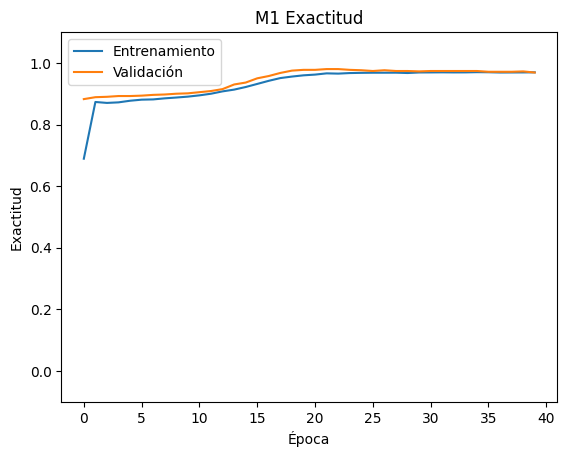

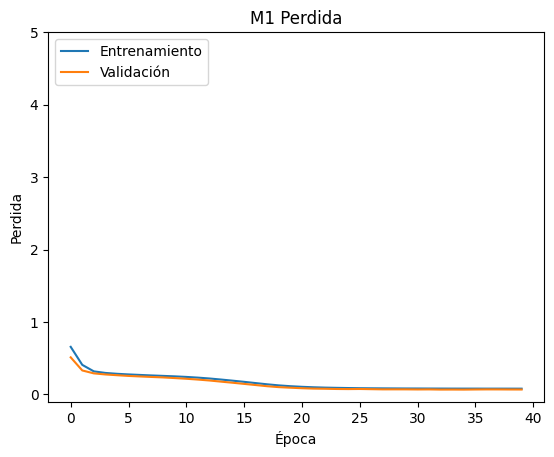

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9661 - loss: 0.0913
test loss, test acc: [0.09318763017654419, 0.9645000100135803]


In [127]:
moons_dim = X_CR_tr[1].shape
moons_dim_SR = X_SR_tr[1].shape
# Generar un inner model nos permitirá usar este como un recurso para aprovechar el procesamiento que se hizo previamente en su entrenamiento, esto para el transfer learning, y aprovechar los pesos que generó para empezar un nuevo entrenamiento, para el caso del fine tuning
m1_inner_model = Sequential(
    [
    Input(shape=moons_dim),
    Dense(5, activation='relu'),
    Dense(5, activation='relu')
    ]
    )
m1 = Sequential(
    [
        m1_inner_model,
        Dense(2, activation='softmax')
    ]
)
opt_adam = keras.optimizers.Adam(learning_rate=0.001)
m1.compile(loss='binary_crossentropy', optimizer=opt_adam, metrics=['accuracy'])
history_m1 = m1.fit(X_SR_tr, y_SR_tr_OHE, epochs=40, validation_split = .1, verbose = 0)

plt.plot(history_m1.history['accuracy'])
plt.plot(history_m1.history['val_accuracy'])
plt.title('M1 Exactitud')
plt.ylabel('Exactitud')
plt.xlabel('Época')
plt.ylim(-0.1, 1.1)
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

plt.plot(history_m1.history['loss'])
plt.plot(history_m1.history['val_loss'])
plt.title('M1 Perdida')
plt.ylabel('Perdida')
plt.xlabel('Época')
plt.ylim(-0.1, 5)
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

m1_res = m1.evaluate(X_SR_ts, y_SR_ts_OHE)
print("test loss, test acc:", m1_res)

# Paso 3: M2, aplicar el mismo modelo al conjunto con ruido

En este caso también se tomo en cuenta el comportamiento del modelo en esta segunda estancia para elegir los parámetros anteriores. En general presentó un buen desempeño y como miraremos más adelante en esta práctica, se tiene un promedio de rendimiento del 86%, que es un buen desempeño y corresponde con lo esperado en el cambio del conjunto

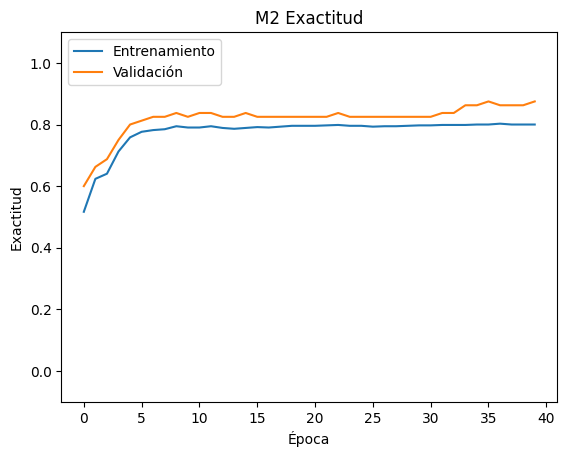

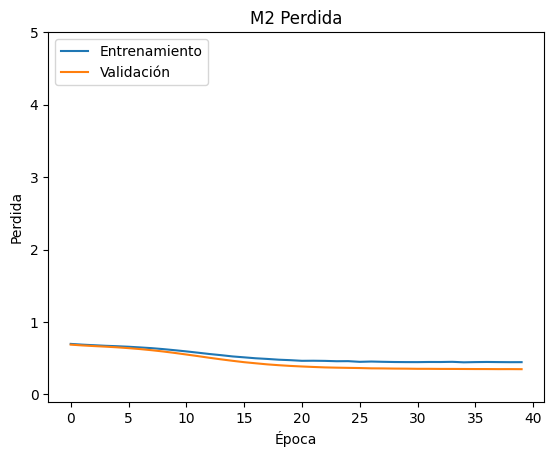

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8654 - loss: 0.3640 
test loss, test acc: [0.3786088526248932, 0.8550000190734863]


In [92]:
m2 = Sequential()
m2.add(Input(shape=moons_dim))
m2.add(Dense(5, activation='relu'))
m2.add(Dense(5, activation='relu'))
m2.add(Dense(2, activation='softmax'))
opt_adam = keras.optimizers.Adam(learning_rate=0.001)
m2.compile(loss='binary_crossentropy', optimizer=opt_adam, metrics=['accuracy'])
history_m2 = m2.fit(X_CR_tr, y_CR_tr_OHE, epochs=40, validation_split = .1, verbose = 0)

plt.plot(history_m2.history['accuracy'])
plt.plot(history_m2.history['val_accuracy'])
plt.title('M2 Exactitud')
plt.ylabel('Exactitud')
plt.xlabel('Época')
plt.ylim(-0.1, 1.1)
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

plt.plot(history_m2.history['loss'])
plt.plot(history_m2.history['val_loss'])
plt.title('M2 Perdida')
plt.ylabel('Perdida')
plt.xlabel('Época')
plt.ylim(-0.1, 5)
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()
m2_res = m2.evaluate(X_CR_ts, y_CR_ts_OHE)
print("test loss, test acc:", m2_res)

## Paso 4: M3, aplicar el transfer learning a M1 y aplicarlo al conjunto con ruido

En este caso, bloqueamos las capas de entrada y ocultas del modelo y entrenamos únicamente la capa de salida, dado que ya existe un aprendizaje previo y deseamos que se ajuste al nuevo conjunto aumentamos la learning rate hasta 0.05, lo cual nos dejó con un desempeño de 0.85 en promedio, lo cuál no aumento el desempeño aunque se mantuvo bien en términos generales

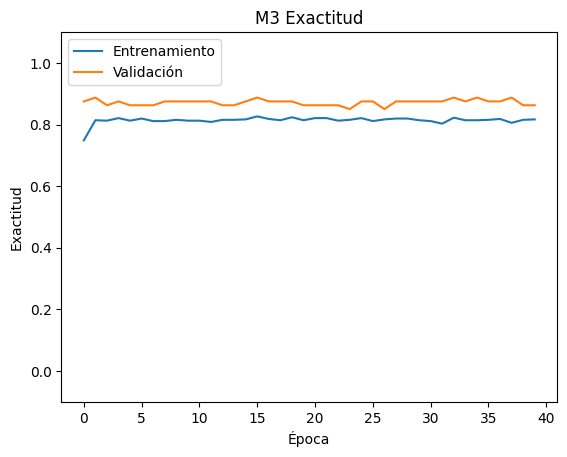

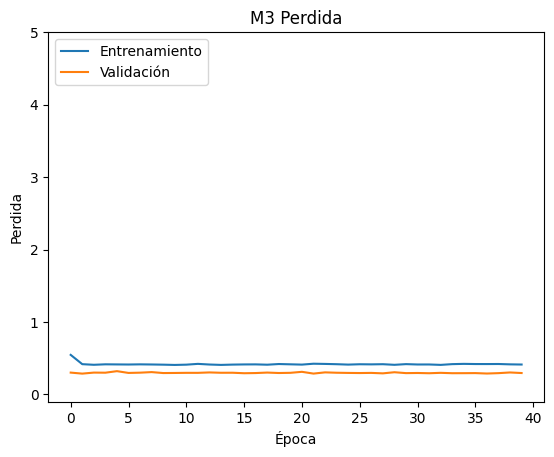

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8543 - loss: 0.3565 
test loss, test acc: [0.3454069495201111, 0.8700000047683716]


In [126]:
# Bloqueamos el aprendizaje de las capas del modelo 1
m1_inner_model.trainable = False
m3 = Sequential(
    [
        m1_inner_model,
        Dense(2, activation='softmax')
    ]
)
opt_adam = keras.optimizers.Adam(learning_rate=0.05)
m3.compile(loss='binary_crossentropy', optimizer=opt_adam, metrics=['accuracy'])
history_m3 = m3.fit(X_CR_tr, y_CR_tr_OHE, epochs=40, validation_split = .1, verbose = 0)

plt.plot(history_m3.history['accuracy'])
plt.plot(history_m3.history['val_accuracy'])
plt.title('M3 Exactitud')
plt.ylabel('Exactitud')
plt.xlabel('Época')
plt.ylim(-0.1, 1.1)
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

plt.plot(history_m3.history['loss'])
plt.plot(history_m3.history['val_loss'])
plt.title('M3 Perdida')
plt.ylabel('Perdida')
plt.xlabel('Época')
plt.ylim(-0.1, 5)
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()
m3_res = m3.evaluate(X_CR_ts, y_CR_ts_OHE)
print("test loss, test acc:", m3_res)


## Paso 4: M3, aplicar el transfer learning a M1 y aplicarlo al conjunto con ruido

En este caso, bloqueamos las capas de entrada y ocultas del modelo y entrenamos únicamente la capa de salida, dado que ya existe un aprendizaje previo y deseamos que se ajuste al nuevo conjunto aumentamos la learning rate hasta 0.05, lo cual nos dejó con un desempeño de 0.85 en promedio, lo cuál no aumento el desempeño aunque se mantuvo bien en términos generales

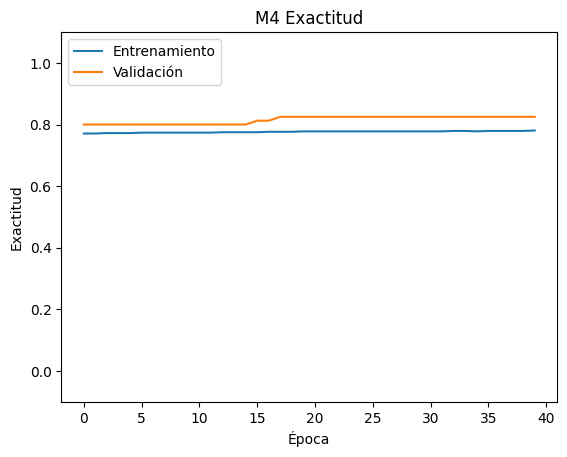

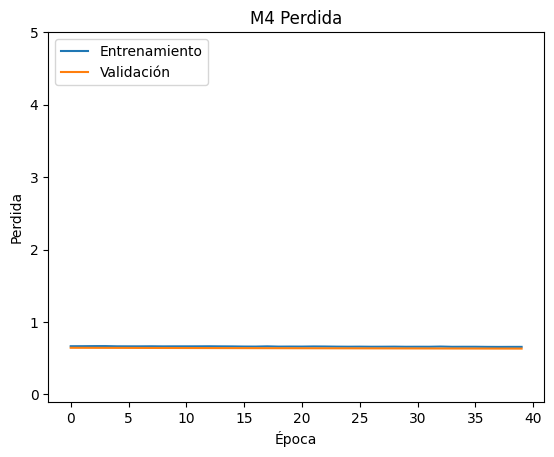

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7795 - loss: 0.6542 
test loss, test acc: [0.6441181898117065, 0.7850000262260437]


In [104]:
#m4_inner_model = clone_model(m1_inner_model) 
m4_inner_model = Sequential(
    [
    Input(shape=moons_dim),
    Dense(5, activation='relu'),
    Dense(5, activation='relu')
    ]
    )
m4_inner_model.set_weights(m1_inner_model.get_weights())
m4 = Sequential(
    [
        m4_inner_model,
        Dense(2, activation='softmax')
    ]
)

opt_adam = keras.optimizers.Adam(learning_rate=0.00001)
m4.compile(loss='binary_crossentropy', optimizer=opt_adam, metrics=['accuracy'])
history_m4 = m4.fit(X_CR_tr, y_CR_tr_OHE, epochs=40, validation_split = .1, verbose = 0)

plt.plot(history_m4.history['accuracy'])
plt.plot(history_m4.history['val_accuracy'])
plt.title('M4 Exactitud')
plt.ylabel('Exactitud')
plt.xlabel('Época')
plt.ylim(-0.1, 1.1)
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

plt.plot(history_m4.history['loss'])
plt.plot(history_m4.history['val_loss'])
plt.title('M4 Perdida')
plt.ylabel('Perdida')
plt.xlabel('Época')
plt.ylim(-0.1, 5)
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()
m4_res = m4.evaluate(X_CR_ts, y_CR_ts_OHE)
print("test loss, test acc:", m4_res)

## Paso 6

In [135]:
m2_res = []
m3_res = []
m4_res = []
m4_inner_model.set_weights(m1_inner_model.get_weights())

for i in range(35):
    m1_inner_model = Sequential(
        [
            Input(shape=moons_dim),
            Dense(5, activation='relu'),
            Dense(5, activation='relu')
        ]
    )
    m1 = Sequential(
        [
            Input(shape=moons_dim),
            m1_inner_model,
            Dense(2, activation='softmax')
        ]
    )
    opt_adam = keras.optimizers.Adam(learning_rate=0.001)
    m1.compile(loss='binary_crossentropy', optimizer=opt_adam, metrics=['accuracy'])
    m1.fit(X_SR_tr, y_SR_tr_OHE, epochs=40, validation_split = .1, verbose = 0)
    # m2
    m2 = Sequential()
    m2.add(Input(shape=moons_dim))
    m2.add(Dense(5, activation='relu'))
    m2.add(Dense(5, activation='relu'))
    m2.add(Dense(2, activation='softmax'))
    opt_adam = keras.optimizers.Adam(learning_rate=0.001)
    m2.compile(loss='binary_crossentropy', optimizer=opt_adam, metrics=['accuracy'])
    m2.fit(X_CR_tr, y_CR_tr_OHE, epochs=40, validation_split = .1, verbose = 0)
    m2_res_it = m2.evaluate(X_CR_ts, y_CR_ts_OHE)
    m2_res.append(m2_res_it[1])
    # m3
    m1_inner_model.trainable = False
    m3 = Sequential(
        [
            m1_inner_model,
            Dense(2, activation='softmax')
        ]
    )
    opt_adam = keras.optimizers.Adam(learning_rate=0.05)
    m3.compile(loss='binary_crossentropy', optimizer=opt_adam, metrics=['accuracy'])
    m3.fit(X_CR_tr, y_CR_tr_OHE, epochs=40, validation_split = .1, verbose = 0)
    m3_res_it = m3.evaluate(X_CR_ts, y_CR_ts_OHE)
    m3_res.append(m3_res_it[1])
    
    # m4
    m4_inner_model = Sequential(
        [
            Input(shape=moons_dim),
            Dense(5, activation='relu'),
            Dense(5, activation='relu')
        ]
    )
    m4_inner_model.set_weights(m1_inner_model.get_weights())
    m4 = Sequential(
        [
            m4_inner_model,
            Dense(2, activation='softmax')
        ]
    )
    
    opt_adam = keras.optimizers.Adam(learning_rate=0.001)
    m4.compile(loss='binary_crossentropy', optimizer=opt_adam, metrics=['accuracy'])
    m4.fit(X_CR_tr, y_CR_tr_OHE, epochs=40, validation_split = .1, verbose = 0)
    m4_res_it = m4.evaluate(X_CR_ts, y_CR_ts_OHE)
    m4_res.append(m4_res_it[1])
    
    keras.backend.clear_session()
   
print(m4_res) 

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8782 - loss: 0.3584 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8646 - loss: 0.3689 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8233 - loss: 0.4840 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8692 - loss: 0.3644 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8713 - loss: 0.3542 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8655 - loss: 0.4107 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8592 - loss: 0.3631 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8531 - loss: 0.3839 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8563 - loss: 0.4504 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8549 - loss: 0.4341 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8718 - loss: 0.3552 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8611 - loss: 0.3546 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8782 - loss: 0.3611 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8245 - loss: 

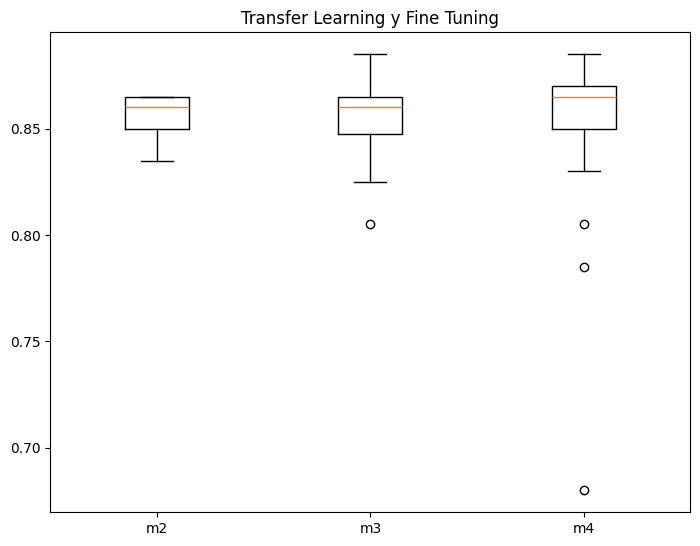

In [136]:
fig = plt.figure()
resultados = {"m2": m2_res, "m3": m3_res, "m4": m4_res} 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot([m2_res, m3_res, m4_res])
ax.set_xticklabels(['m2', 'm3', 'm4'])
plt.title("Transfer Learning y Fine Tuning")
#plt.ylim(-0.1, 1) 
# show plot
plt.show()

In [137]:
min_m2 = min(m2_res)
max_m2 = max(m2_res)
mean_m2 = np.mean(m2_res)
median_m2 = np.median(m2_res)
std_dev_m2 = np.std(m2_res)

min_m3 = min(m3_res)
max_m3 = max(m3_res)
mean_m3 = np.mean(m3_res)
median_m3 = np.median(m3_res)
std_dev_m3 = np.std(m3_res)

min_m4 = min(m4_res)
max_m4 = max(m4_res)
mean_m4 = np.mean(m4_res)
median_m4 = np.median(m4_res)
std_dev_m4 = np.std(m4_res)

head = ["Modelo", "Mínimo", "μ + σ", "Mediana", "Máximo"]
data = [['m2', "{:.2f}".format(min_m2), "{:.2f}".format(mean_m2) + "±" + "{:.2f}".format(std_dev_m2), "{:.2f}".format(median_m2), "{:.2f}".format(max_m2)],
['m3', "{:.2f}".format(min_m3), "{:.2f}".format(mean_m3) + "±" + "{:.2f}".format(std_dev_m3), "{:.2f}".format(median_m3), "{:.2f}".format(max_m3)],
['m4', "{:.2f}".format(min_m4), "{:.2f}".format(mean_m4) + "±" + "{:.2f}".format(std_dev_m4), "{:.2f}".format(median_m4), "{:.2f}".format(max_m4)]]
print (tabulate(data, headers=["Modelo", "Mínimo", "μ + σ", "Mediana", "Máximo"]))

Modelo      Mínimo  μ + σ        Mediana    Máximo
--------  --------  ---------  ---------  --------
m2            0.83  0.86±0.01       0.86      0.87
m3            0.81  0.86±0.02       0.86      0.88
m4            0.68  0.85±0.04       0.87      0.88
